## CE-like background in onspill 

SAM definition: `nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root` 

## Imports

Switched to using installed pyutils package

In [1]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector
from pyutils.pylogger import Logger
logger = Logger(print_prefix="[ana]")

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse, Utils
from postprocess import PostProcess
from efficiency import Efficiency 
from draw import Draw

## Set file output tag

In [2]:
# Get today's date in MM-DD-YY format
today = datetime.now().strftime("%m-%d-%y")
# tag = "test_plot" # today
ds_type = "onspill"
tag = ds_type + "_CRY_LH_au_" + today

# Create Processor 

We inherit from Skeleton - this gives us many pre-built methods without writing extra code

In [3]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root"

        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = "disk"     # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=True,
            verbosity=0
        )

        self.logger = Logger(
            print_prefix = "[CosmicProcessor]"
        )
            
        # Toggle cuts OFF
        # self.inactive_cuts = []
            
        # Custom prefix for log messages from this processor
        self.logger.log("Initialised", "success")
        
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(this_data, file_name)

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            self.logger.log(f"Error processing {file_name}: {e}", "success")
            return None

# Create an instance of our custom processor
cosmic_processor = CosmicProcessor()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] ✅ Initialised


In [4]:
# ==========================================
# Run the processor
# ==========================================

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# This starts a parent Processor and submits the process function to the threads

# Execute your processor
results = cosmic_processor.execute()

[CosmicProcessor] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root
	Count: 821 files
[pyprocess] ⭐️ Starting processing on 821 files with 50 processes


Processing: 100%|██████████████████████████████| 821/821 [04:27<00:00,  3.06file/s, successful=821, failed=0]

[pyprocess] ⭐️ Returning 821 results
[CosmicProcessor] ✅ Analysis complete


## Run postprocessing

In [5]:
# help(PostProcess)

In [6]:
postprocessor = PostProcess(info=True)
data, hists, stats, info = postprocessor.execute(results)

[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 6 events
[PostProcess] ✅ Combined 4 histograms over 821 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Retrieved background event info
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats


## Analyse results

### Cut statisics 

In [7]:
cut_manager = CutManager()
def get_cut_stats_df(out_path=f"../../txt/{ds_type}/{ds_type}_cut_stats_{tag}.csv"):
    df_stats = cut_manager.get_cut_stats(stats=stats, active_only=True, printout=False)
    df_stats.to_csv(out_path, index=False)
    display(df_stats)
    logger.log(f"Wrote {out_path}", "success")
    return df_stats

df_stats = get_cut_stats_df()

[CutManager] ✅ Created cut statistics DataFrame 


,Cut,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,2189973,100.00,100.00,No selection applied
1,is_reco_electron,2116233,96.63,96.63,Electron track fits
2,has_trk_front,2098551,95.83,99.16,Tracks intersect tracker entrance
3,good_trkqual,369869,16.89,17.62,Track fit quality > 0.8
4,within_t0,301192,13.75,81.43,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,is_downstream,214801,9.81,71.32,Downstream tracks (p_z > 0 at tracker entrance)
6,has_hits,214240,9.78,99.74,>20 active tracker hits
7,within_d0,77473,3.54,36.16,Distance of closest approach (d_0 < 100 mm)
8,within_pitch_angle,42365,1.93,54.68,Extrapolated pitch angle (0.557735 < tan(theta...
9,within_lhr_max,34031,1.55,80.33,Loop helix maximum radius (450 < R_max < 680 mm)


[ana] ✅ Wrote ../../txt/onspill/onspill_cut_stats_onspill_CRY_LH_au_07-30-25.csv


## Efficiency 

In [18]:

from efficiency import Efficiency 
eff = Efficiency()

# def get_eff_from_df(df_stats, out_path=f"../../txt/{ds_type}/{ds_type}_eff_from_df_{tag}.csv"):
#     logger.log(f"Efficiency from cuts DataFrame:", "info")
#     df_eff = eff.get_eff_from_df(df_stats, N_gen=4e6/812, veto=True, wilson=True)
#     df_eff.to_csv(out_path, index=False)
#     display(df_eff)
#     logger.log(f"Wrote {out_path}", "success")
#     return df_eff

def get_eff_from_hists(hists, out_path=f"../../txt/{ds_type}/{ds_type}_eff_from_hist_{tag}.csv"):
    logger.log(f"Efficiency from histograms:", "info")
    df_eff = eff.get_eff_from_hists(hists, N_gen=4e6, veto=True, wilson=True)
    df_eff.round(3).to_csv(out_path, index=False)
    display(df_eff.round(3))
    logger.log(f"Wrote {out_path}", "success")
    return df_eff
    
# df_eff_from_df = get_eff(df_stats)
df_eff_from_hist = get_eff_from_hists(hists)

[Efficiency] ⭐️ Initialised
[ana] ⭐️ Efficiency from histograms:
[Efficiency] ⭐️ Getting efficiency from histogams
[Efficiency] ✅ Returning efficiency information


,Type,Events Passing (k),Total Events (N),Efficiency [%],Efficiency Error [%]
0,Signal (wide),11961,4000000,0.299,0.003
1,Signal (ext),1590,4000000,0.040,0.001
2,Signal (sig),165,4000000,0.004,0.000
3,Veto (wide),6,11961,99.950,0.021
4,Veto (ext),2,1590,99.874,0.094
5,Veto (sig),1,165,99.394,0.672


[ana] ✅ Wrote ../../txt/onspill/onspill_eff_from_hist_onspill_CRY_LH_au_07-30-25.csv


## Retreive background event info 

In [10]:
utils = Utils()

# General info
utils.write_background_events(
    info, 
    printout=True, 
    out_path=f"../../txt/{ds_type}/{ds_type}_background_event_info_{tag}.txt"
)

# Verbose event-level info
utils.write_verbose_background_events(
    data, 
    out_path=f"../../txt/{ds_type}/{ds_type}_verbose_background_event_info_{tag}.txt"
)

[pyprint] ⭐️ Initialised Print with verbose = True and precision = 1
[PostProcess] ⭐️ Initialised
[PostProcess] ⭐️ Background event info:
  Index:            58
  Subrun:           [4846]
  Event:            [283585]
  File:             nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00000075.root
  Track time [ns]:  1445.887901
  Coinc time [ns]:  None
  dt [ns]:          N/A
----------------------------------------
  Index:            207
  Subrun:           [19742]
  Event:            [359830]
  File:             nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00015581.root
  Track time [ns]:  822.773672
  Coinc time [ns]:  None
  dt [ns]:          N/A
----------------------------------------
  Index:            261
  Subrun:           [25833]
  Event:            [93561]
  File:             nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00024906.root
  Track time [ns]:  1499.100000
  

## Draw histograms 

FIXME: can you put these histogramming functions in a common module, probably called histogrammer.py... 

Momentum and z-position

[Plot] ⭐️ Initialised
[Plot] ✅ 	Wrote ../../img/onspill/h1o_1x3_mom_win_onspill_CRY_LH_au_07-30-25.png


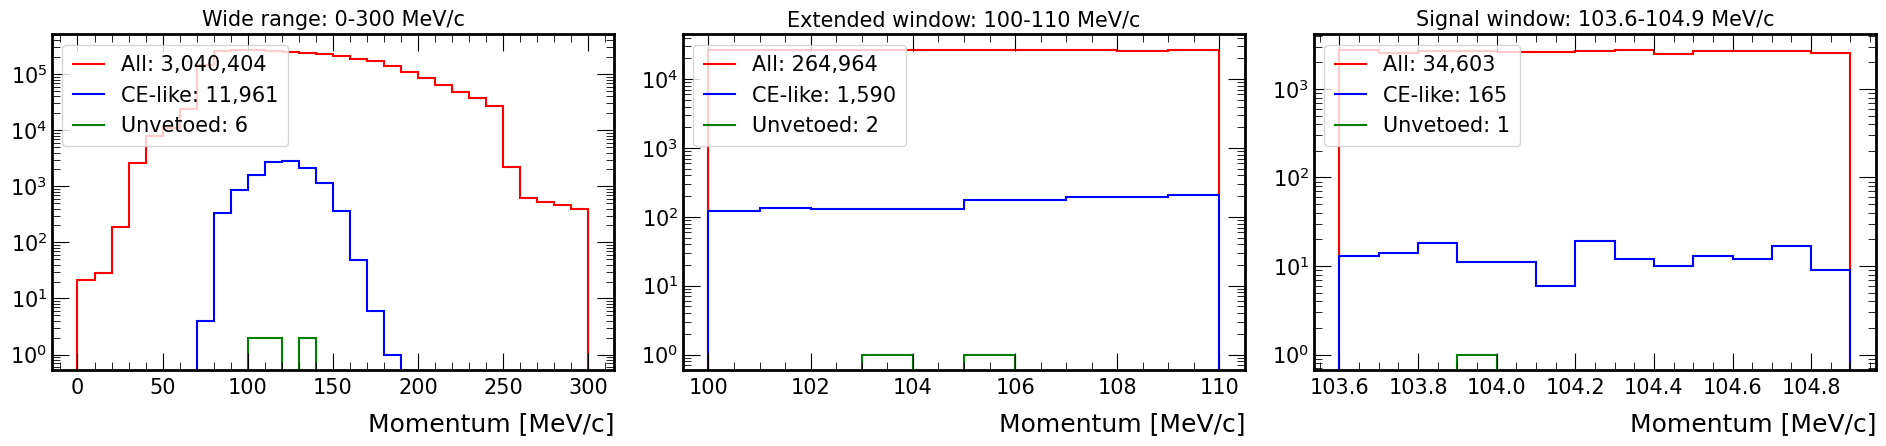

In [12]:
from draw import Draw
draw = Draw()

draw.plot_mom_windows(hists, out_path=f"../../img/{ds_type}/h1o_1x3_mom_win_{tag}.png")

### z-position plots

/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/mplhep/utils.py:560: RuntimeWarning: divide by zero encountered in scalar divide
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/mplhep/utils.py:531: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/mplhep/utils.py:532: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/mplhep/utils.py:533: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale


[Plot] ✅ 	Wrote ../../img/onspill/h1o_crv_z_onspill_CRY_LH_au_07-30-25.png


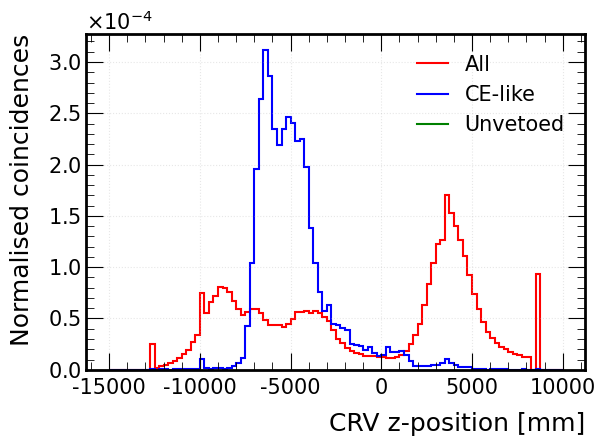

In [13]:
draw.plot_crv_z(hists, out_path=f"../../img/{ds_type}/h1o_crv_z_{tag}.png")

/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/hist/basehist.py:444: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


[ana] ✅ 	Wrote ../../img/onspill/h1o_crv_z_onspill_CRY_LH_au_07-30-25.png


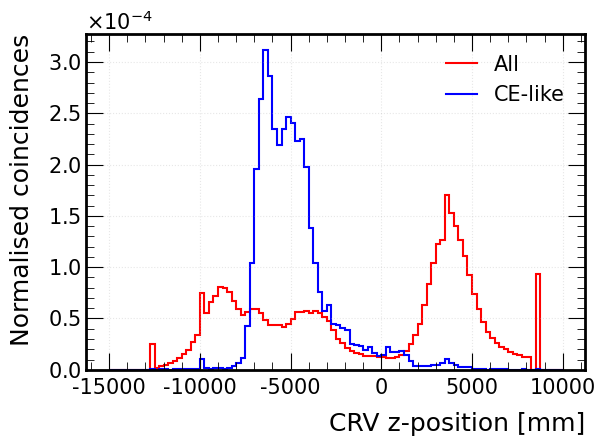

{'mom_full': Hist(
  Regular(30, 0, 300, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All', 'CE-like', 'Unvetoed'], name='selection', label='Selection'),
  storage=Double()) # Sum: 3052371.0 (3055779.0 with flow), 'mom_ext': Hist(
  Regular(10, 100, 110, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All', 'CE-like', 'Unvetoed'], name='selection', label='Selection'),
  storage=Double()) # Sum: 266556.0, 'mom_sig': Hist(
  Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All', 'CE-like', 'Unvetoed'], name='selection', label='Selection'),
  storage=Double()) # Sum: 34769.0, 'crv_z': Hist(
  Regular(100, -15000, 10000, name='crv_z', label='CRV z-position [mm]'),
  StrCategory(['All', 'CE-like', 'Unvetoed'], name='selection', label='Selection'),
  storage=Double()) # Sum: 2366416.0}


In [14]:
def plot_crv_z(hists, out_path=None):
    """
    Plot CRV z-position histograms
    """
    # 1x3 subplots
    fig, ax = plt.subplots() 
    # Wide range 
    selection = "crv_z"
    h1o_z = hists[selection]
    h1o_z = h1o_z[{"selection": ["All", "CE-like"]}]
    h1o_z.plot1d(overlay="selection", density=True, ax=ax)
    # Format
    ax.grid(True, alpha=0.3)
    ax.set_ylabel("Normalised coincidences")
    ax.legend(["All", "CE-like", "Unvetoed"], frameon=False, loc="upper right")
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0,0), useMathText=True)

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300)
        logger.log(f"\tWrote {out_path}", "success")
    plt.show()

plot_crv_z(hists, out_path=f"../../img/{ds_type}/h1o_crv_z_{tag}.png")

print(hists)

## Find parent cosmic particle ID

These are `trkmcsim` entries of rank -1, with the highest momentum. 

In [ ]:
# data

In [15]:
vector = Vector()

def is_cosmic_parent(data): 
    # Rank condition
    rank_condition = data["trkmc"]["trkmcsim"]["rank"] == -1
    # Then by momentum 
    mom_mag = vector.get_mag(data["trkmc"]["trkmcsim"], "mom")
    data["mom_mag"] = mom_mag
    mom_condition = mom_mag == ak.max(mom_mag, axis=-1)
    # Combine
    mask = rank_condition & mom_condition
    return mask
    
cosmic_parent_mask = is_cosmic_parent(data)
data["cosmic_parent"] = cosmic_parent_mask

# # # # print(cosmic_parent_mask)
data["trkmc"] = data["trkmc"][cosmic_parent_mask]
data["mom_mag"] = data["mom_mag"][cosmic_parent_mask]

# printer.print_n_events(data, n_events=len(data))

# For some reason we have duplicates in here, so just take the first one 
cosmic_parent_pdg = ak.flatten(data["trkmc"]["trkmcsim"]["pdg"][:,:,0])
print("cosmic_parent_pdg", cosmic_parent_pdg) 


[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
cosmic_parent_pdg [13, 2112, 2112, 2112, 2112, 13]


	Wrote ../../img/onspill/bar_cosmic_parents_onspill_CRY_LH_au_07-30-25.png


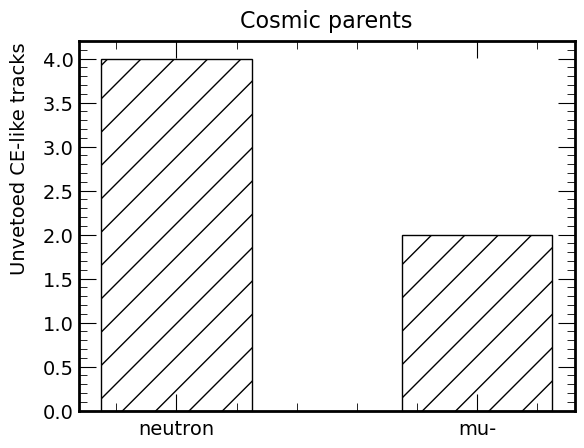

In [16]:
pdg_to_label = {
    11: "e-", -11: "e+",
    13: "mu-", -13: "mu+", 
    2112: "neutron", -2112: "antineutron",
    2212: "proton", -2212: "antiproton",
    22: "gamma", 111: "pi0",
    211: "pi+", -211: "pi-"
}

def BarChart(data, label_dict, title=None, xlabel=None, ylabel=None, fout="bar_chart.png", percentage=False, bar_alpha=1.0, bar_color='black', NDPI=300):
    """ Pulled from Mu2eCool repo 
    Needs update, but it works fine"""
    
    # Matches the key of the dict with row in the data array and returns the element as the label
    labels = [label_dict.get(p, 'other') for p in data]

    # Count occurrences of each label
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Only works for particles 

    # Sort labels and counts in descending order
    sorted_indices = np.argsort(label_counts)[::-1]
    unique_labels = unique_labels[sorted_indices]
    label_counts = label_counts[sorted_indices]

    if percentage: 
        label_counts = (label_counts / np.sum(label_counts))*100

    plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
    
    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot the bar chart
    indices = np.arange(len(unique_labels))

    # TODO: handle this better
    n_bars = len(indices)
    bar_width = 3.0 / n_bars
    if(n_bars == 3.0): 
        bar_width = 2.0 / n_bars
    elif(n_bars == 2.0):
        bar_width = 1.0 / n_bars

    ax.bar(indices, label_counts, align='center', alpha=bar_alpha, color=bar_color, width=bar_width, fill=False, hatch='/', linewidth=1, edgecolor='black')

    # Set x-axis labels
    ax.set_xticks(indices)
    ax.set_xticklabels(unique_labels, rotation=0) # 45)

    # Set labels for the chart
    ax.set_title(title, fontsize=16, pad=10)
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=14)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=14)  # Set y-axis tick label font size

    if ax.get_ylim()[1] > 999:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(14)

    # Save the figure
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    print("\tWrote", fout)


BarChart(
    cosmic_parent_pdg,
    pdg_to_label,
    title="Cosmic parents",
    ylabel="Unvetoed CE-like tracks",
    fout=f"../../img/{ds_type}/bar_cosmic_parents_{tag}.png"
    
)